In [1]:
# Imorting necessary libraries
from imutils import paths
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import tensorflow as tf
#from tensorflow.keras.preprocessing.image import load_img, img_to_array, array_to_img
from tensorflow.keras import Model, Sequential
from tensorflow.keras import layers
    
# Setting some variables for plotting via matplotlib
plt.rcParams["figure.figsize"] = (10, 10)
plt.rc('xtick', labelsize=15) 
plt.rc('ytick', labelsize=15) 
plt.rc('lines', linewidth=3)
plt.rc('font', size=15)

2024-06-12 13:04:57.771601: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-12 13:04:57.806709: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-12 13:04:58.408657: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
import random

random.seed(10)
np.random.seed(10)
tf.random.set_seed(10)

In [3]:
# Find and load normal image directories into a list
directory_test = '/mnt/f/Diplom/archive_2/chest_xray/chest_xray/test/NORMAL'
directory_train = '/mnt/f/Diplom/archive_2/chest_xray/chest_xray/train/NORMAL/'
directory_val = '/mnt/f/Diplom/archive_2/chest_xray/chest_xray/val/NORMAL/'
image_paths_norm = sorted(list(paths.list_images(directory_test))) + \
                   sorted(list(paths.list_images(directory_train))) + \
                   sorted(list(paths.list_images(directory_val)))

# Declare a normal label list
labels_norm = ['Normal'] * len(image_paths_norm)

In [4]:
# Find and load pneumonia image directories into a list
directory_test_pn = '/mnt/f/Diplom/archiveTB/TBX11K/imgs/tb_test'
directory_train_pn = '/mnt/f/Diplom/archiveTB/TBX11K/imgs/tb_train'
directory_val_pn = '/mnt/f/Diplom/archiveTB/TBX11K/imgs/tb_val'
image_paths_pn = sorted(list(paths.list_images(directory_test_pn))) + \
                 sorted(list(paths.list_images(directory_train_pn))) + \
                 sorted(list(paths.list_images(directory_val_pn)))

# Declare a pneumonia label list for binary
labels_pn = ['Tuberculosis'] * len(image_paths_pn)

# Merge the image and label lists together and turn them into NumPy arrays
image_paths = np.array(image_paths_norm + image_paths_pn)
labels = np.concatenate((labels_norm, labels_pn))

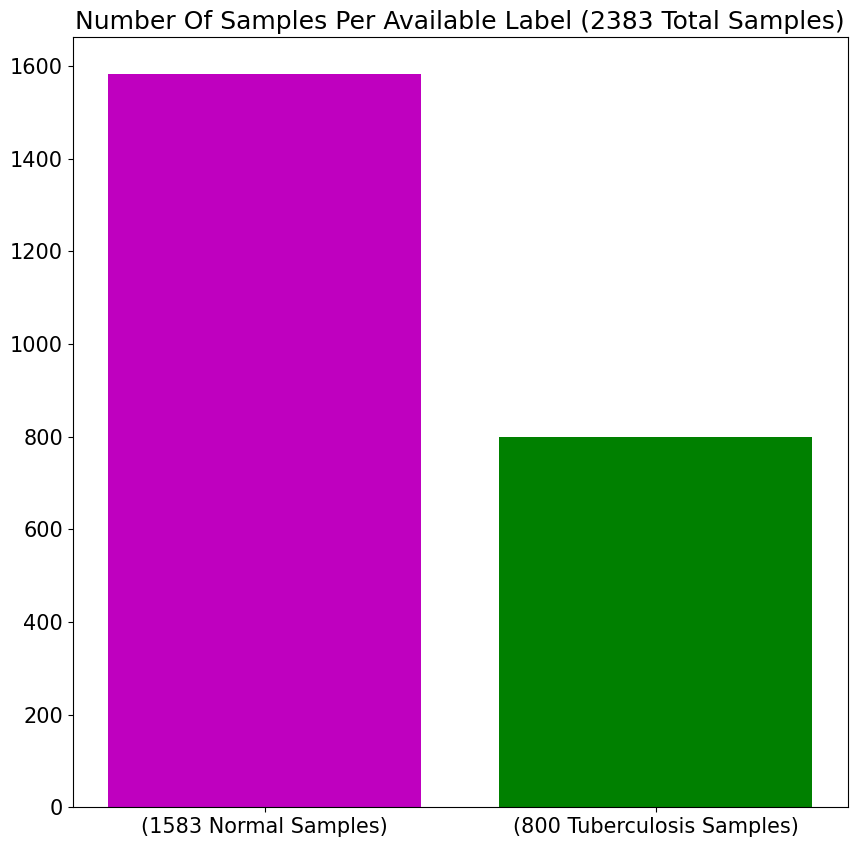

In [5]:
# Plot a bar with numbers of normal and pneumonia diagnoses
plt.bar([1, 2], height=[len(labels_norm), len(labels_pn)], 
        tick_label=['({0:d} Normal Samples)'.format(len(labels_norm)), 
                    '({0:d} Tuberculosis Samples)'.format(len(labels_pn))],
        color=['m', 'g'])

plt.title('Number Of Samples Per Available Label ({0:d} Total Samples)'.
          format(len(labels_norm) + len(labels_pn)))

plt.show()

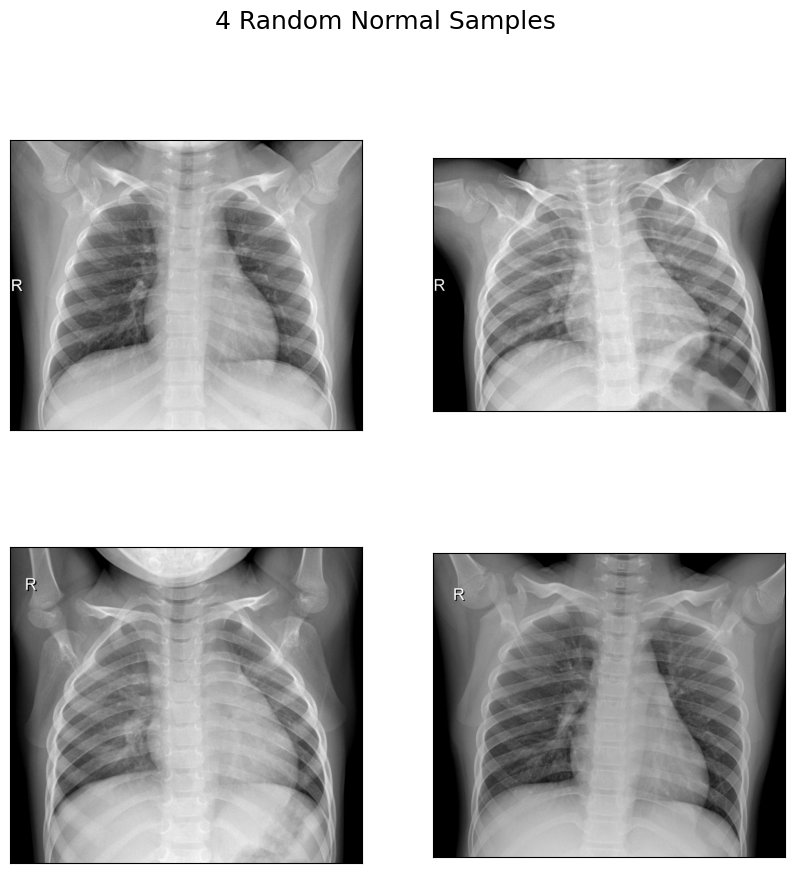

In [6]:
from keras.api.utils import load_img #tf 2.16.1
#from keras.utils import load_img #tf 2.15.0
# Build a 2 x 2 figure
rows, columns = 2, 2
fig, axes = plt.subplots(rows, columns)

# Choose random indices for image selection
norm_indices = np.random.choice(len(image_paths_norm), rows * columns)
pn_indices = np.random.choice(len(image_paths_pn), rows * columns)

# Make a list with images to plot
imgs_to_plot_norm = [image_paths_norm[i] for i in norm_indices]
imgs_to_plot_pn = [image_paths_pn[i] for i in pn_indices]

# Variable used for indending through the image list
current_index = 0

# Set figure title
fig.suptitle('4 Random Normal Samples')

# Plot normal images
for i in range(rows):
    for j in range(columns):
        img = load_img(imgs_to_plot_norm[current_index])        
        axes[i, j].imshow(img)
        axes[i, j].set_xticks([])
        axes[i, j].set_yticks([])
        current_index +=1
        
plt.show()

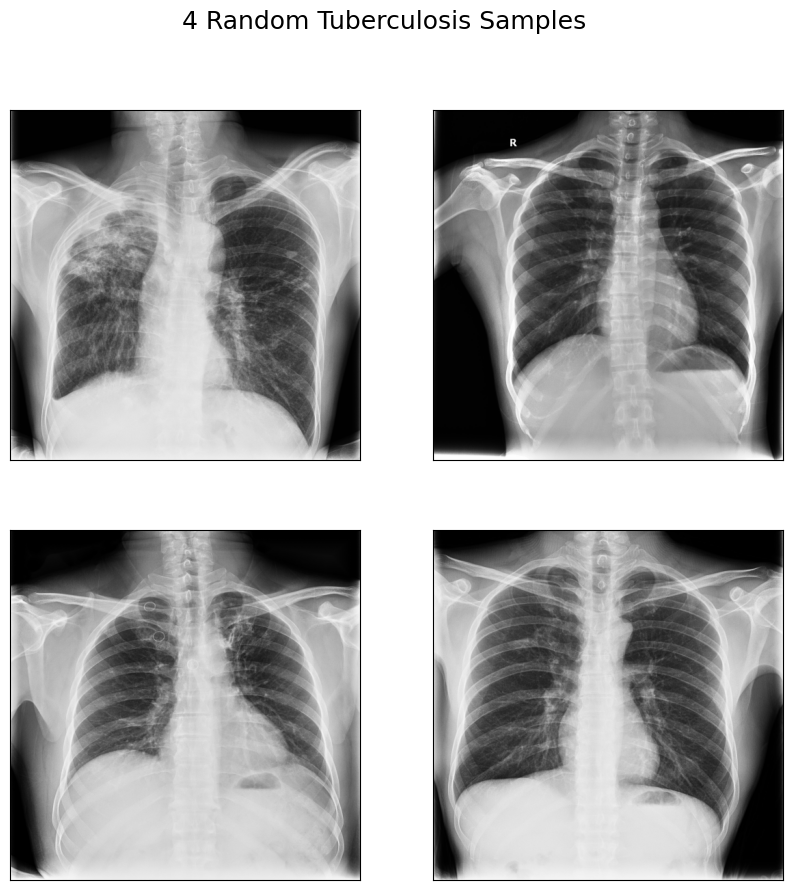

In [7]:
fig, axes = plt.subplots(rows, columns)

current_index = 0

# Set figure title
fig.suptitle('4 Random Tuberculosis Samples')

# Plot pneumonia images
for i in range(rows):
    for j in range(columns):
        img = load_img(imgs_to_plot_pn[current_index])        
        axes[i, j].imshow(img)
        axes[i, j].set_xticks([])
        axes[i, j].set_yticks([])
        current_index +=1
        
plt.show()

In [8]:
from sklearn.model_selection import train_test_split

# Divide the image path & label arrays into train & test sets. This is done without loading images to save memory
X_train_dir, X_test_dir, y_train, y_test = \
                                           train_test_split(image_paths, labels, test_size=0.3)

# Divide the test set into validation (for use during training) and test (for post-training evaulation) sets
X_val_dir, y_val = X_test_dir[:len(X_test_dir) // 2], \
                   y_test[:len(y_test) // 2]

X_test_dir, y_test = X_test_dir[len(X_test_dir) // 2:], \
                     y_test[len(y_test) // 2:]

In [9]:
# Create DataFrames for the image generator
train_df = pd.DataFrame(np.transpose([X_train_dir, y_train]), 
                        columns=['filename', 'class'])

val_df = pd.DataFrame(np.transpose([X_val_dir, y_val]), 
                      columns=['filename', 'class'])

test_df = pd.DataFrame(np.transpose([X_test_dir, y_test]), 
                       columns=['filename', 'class'])

In [10]:
#from keras.preprocessing.image import ImageDataGenerator #tf 2.15.0
from keras._tf_keras.keras.preprocessing.image import ImageDataGenerator #tf 2.16.1
# Set the batch size for the generator and training
BATCH_SIZE = 10

# Declare an image generator for image augmentation
datagen = ImageDataGenerator(rescale = 1./255,
                             zoom_range=0.1, 
                             height_shift_range=0.05, 
                             width_shift_range=0.05,
                             rotation_range=5)


# Declare an image generator for validation & testing without generation
test_datagen = ImageDataGenerator(rescale = 1./255)

# Declare generators for training, validation, and testing from DataFrames
train_gen = datagen.flow_from_dataframe(train_df,
                                        target_size=(512, 512),
                                        color_mode='grayscale',
                                        batch_size=BATCH_SIZE,
                                        class_mode='binary',
                                        shuffle=True)

val_gen = test_datagen.flow_from_dataframe(val_df,
                                        target_size=(512, 512),
                                        color_mode='grayscale',
                                        batch_size=BATCH_SIZE,
                                        class_mode='binary',
                                        shuffle=False)

test_gen = test_datagen.flow_from_dataframe(test_df,
                                        target_size=(512, 512),
                                        color_mode='grayscale',
                                        batch_size=BATCH_SIZE,
                                        class_mode='binary',
                                        shuffle=False)

Found 1668 validated image filenames belonging to 2 classes.
Found 357 validated image filenames belonging to 2 classes.
Found 358 validated image filenames belonging to 2 classes.


In [11]:
# Declare TensorFlow Datasets for more efficient training
train_data = tf.data.Dataset.from_generator(lambda: train_gen,
                                            output_types=(tf.float32, tf.int32),
                                            output_shapes=([None, 512, 512, 1], [None, ]))

val_data = tf.data.Dataset.from_generator(lambda: val_gen,
                                          output_types=(tf.float32, tf.int32),
                                          output_shapes=([None, 512, 512, 1], [None, ]))

test_data = tf.data.Dataset.from_generator(lambda: test_gen,
                                           output_types=(tf.float32, tf.int32),
                                           output_shapes=([None, 512, 512, 1], [None, ]))

2024-06-12 13:05:36.491515: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-12 13:05:36.736746: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-12 13:05:36.736808: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-12 13:05:36.740280: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-12 13:05:36.740346: I external/local_xla/xla/stream_executor

In [12]:
from keras.api.utils import img_to_array #tf 2.16.1
#from keras.utils import img_to_array #tf 2.15.0
images_to_augment = []

for image_path in image_paths[:4]:
    image = load_img(image_path, target_size=(512, 512))
    image = img_to_array(image)
    images_to_augment.append(image)
    
images_to_augment = np.array(images_to_augment)

images_augmented = next(datagen.flow(x=images_to_augment,
                                batch_size=10,
                                shuffle=False))

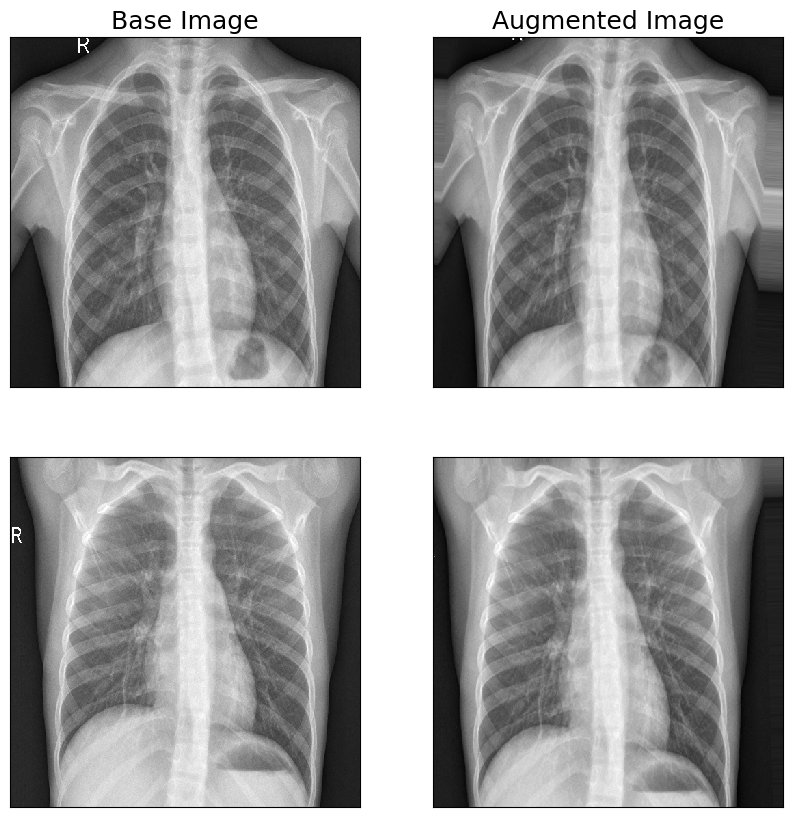

In [13]:
from keras.api.utils import array_to_img #tf 2.16.1
#from keras.utils import array_to_img #tf 2.15.0

fig, axes = plt.subplots(2, 2)

for i in range(2):
    axes[i, 0].imshow(array_to_img(images_to_augment[i]), 
                      interpolation='nearest')
    
    axes[i, 1].imshow(array_to_img(images_augmented[i]), 
                      interpolation='nearest')
    
    axes[i, 0].set_xticks([])
    axes[i, 1].set_xticks([])
    
    axes[i, 0].set_yticks([])
    axes[i, 1].set_yticks([])
    
columns = ['Base Image', 'Augmented Image']
for ax, column in zip(axes[0], columns):
    ax.set_title(column) 
    
plt.show()

In [14]:
def feed_data(dataset):
    """Feed data to a model with prefetching
    
    Arguments:
        dataset (tf.Dataset): A dataset that to be fed to the model
        
    Returns:
        dataset (tf.Dataset): A prefetched dataset
    """
    
    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)  
    
    return dataset

In [15]:
# Define the CNN Keras model
def create_model():
    """
    Create a model
    
    Returns:
        model (tf.keras.Model): An instance of Model
    """
    
    # Model input
    input_layer = layers.Input(shape=(512, 512, 1), name='input')    

    # First block
    x = layers.Conv2D(filters=64, kernel_size=3, 
                      activation='relu', padding='same', 
                      name='conv2d_1')(input_layer)
    x = layers.MaxPool2D(pool_size=2, name='maxpool2d_1')(x)
    x = layers.Dropout(0.1, name='dropout_1')(x)
    
    # Second block
    x = layers.Conv2D(filters=96, kernel_size=3, 
                      activation='relu', padding='same', 
                      name='conv2d_2')(x)
    x = layers.MaxPool2D(pool_size=2, name='maxpool2d_2')(x)
    x = layers.Dropout(0.1, name='dropout_2')(x)

    # Third block
    x = layers.Conv2D(filters=128, kernel_size=3, 
                      activation='relu', padding='same', 
                      name='conv2d_3')(x)
    x = layers.MaxPool2D(pool_size=2, name='maxpool2d_3')(x)
    x = layers.Dropout(0.1, name='dropout_3')(x)
    
    # Fourth block
    x = layers.Conv2D(filters=160, kernel_size=3, 
                      activation='relu', padding='same', 
                      name='conv2d_4')(x)
    x = layers.MaxPool2D(pool_size=2, name='maxpool2d_4')(x)
    x = layers.Dropout(0.1, name='dropout_4')(x)

    # Fifth block
    x = layers.Conv2D(filters=192, kernel_size=3, 
                      activation='relu', padding='same', 
                      name='conv2d_5')(x)
    x = layers.MaxPool2D(pool_size=2, name='maxpool2d_5')(x)
    x = layers.Dropout(0.1, name='dropout_5')(x)
    
    # Sixth block
    x = layers.Conv2D(filters=224, kernel_size=3, 
                      activation='relu', padding='same', 
                      name='conv2d_6')(x)
    x = layers.MaxPool2D(pool_size=2, name='maxpool2d_6')(x)
    x = layers.Dropout(0.1, name='dropout_6')(x)
    
    # Seventh block
    x = layers.Conv2D(filters=256, kernel_size=3, 
                      activation='relu', padding='same', 
                      name='conv2d_7')(x)
    x = layers.MaxPool2D(pool_size=2, name='maxpool2d_7')(x)
    x = layers.Dropout(0.1, name='dropout_7')(x)

    # Pooling and output
    x = layers.GlobalAveragePooling2D(name='global_average_pooling2d')(x)    
    output = layers.Dense(units=1, 
                          activation='sigmoid', 
                          name='output')(x)

    # Model creation and compilation
    
    model = Model (input_layer, output)    
    model.compile(optimizer='adam', 
                  loss='binary_crossentropy', 
                  metrics=['accuracy'])

    return model

In [16]:
# Create a Model object
model = create_model()

In [20]:
# See the layer and parameter summary
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 512, 512, 1)]     0         
                                                                 
 conv2d_1 (Conv2D)           (None, 512, 512, 64)      640       
                                                                 
 maxpool2d_1 (MaxPooling2D)  (None, 256, 256, 64)      0         
                                                                 
 dropout_1 (Dropout)         (None, 256, 256, 64)      0         
                                                                 
 conv2d_2 (Conv2D)           (None, 256, 256, 96)      55392     
                                                                 
 maxpool2d_2 (MaxPooling2D)  (None, 128, 128, 96)      0         
                                                                 
 dropout_2 (Dropout)         (None, 128, 128, 96)      0     

In [40]:
from tensorflow.keras import regularizers
from keras.src.applications.vgg16 import VGG16
from keras._tf_keras.keras.layers import Dense, Dropout, Flatten, Input

# We use transfer learning with VGG16 as the base model
def CNN_Model():
    base_model = VGG16(weights='imagenet', include_top = False, input_shape=(256, 256, 3))
    # Freeze the base model
    for layer in base_model.layers:
        layer.trainable = False

    for i in range(3):
        base_model.layers[-2-i].trainable = True

    CNN = Sequential()
    CNN.add(Input(shape=(256, 256, 3)))
    CNN.add(base_model)
    CNN.add(Flatten())
    CNN.add(Dropout(0.3))
    CNN.add(Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.05)))
    CNN.add(Dropout(0.2))
    CNN.add(Dense(2, activation='sigmoid'))
    
    return CNN

# Training The CNN
model = CNN_Model()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()  

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 8, 8, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 128)            │     4,194,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,909,378 (72.13 MB)

 Trainable params: 11,274,114 (43.01 MB)

 Non-trainable params: 7,635,264 (29.13 MB)

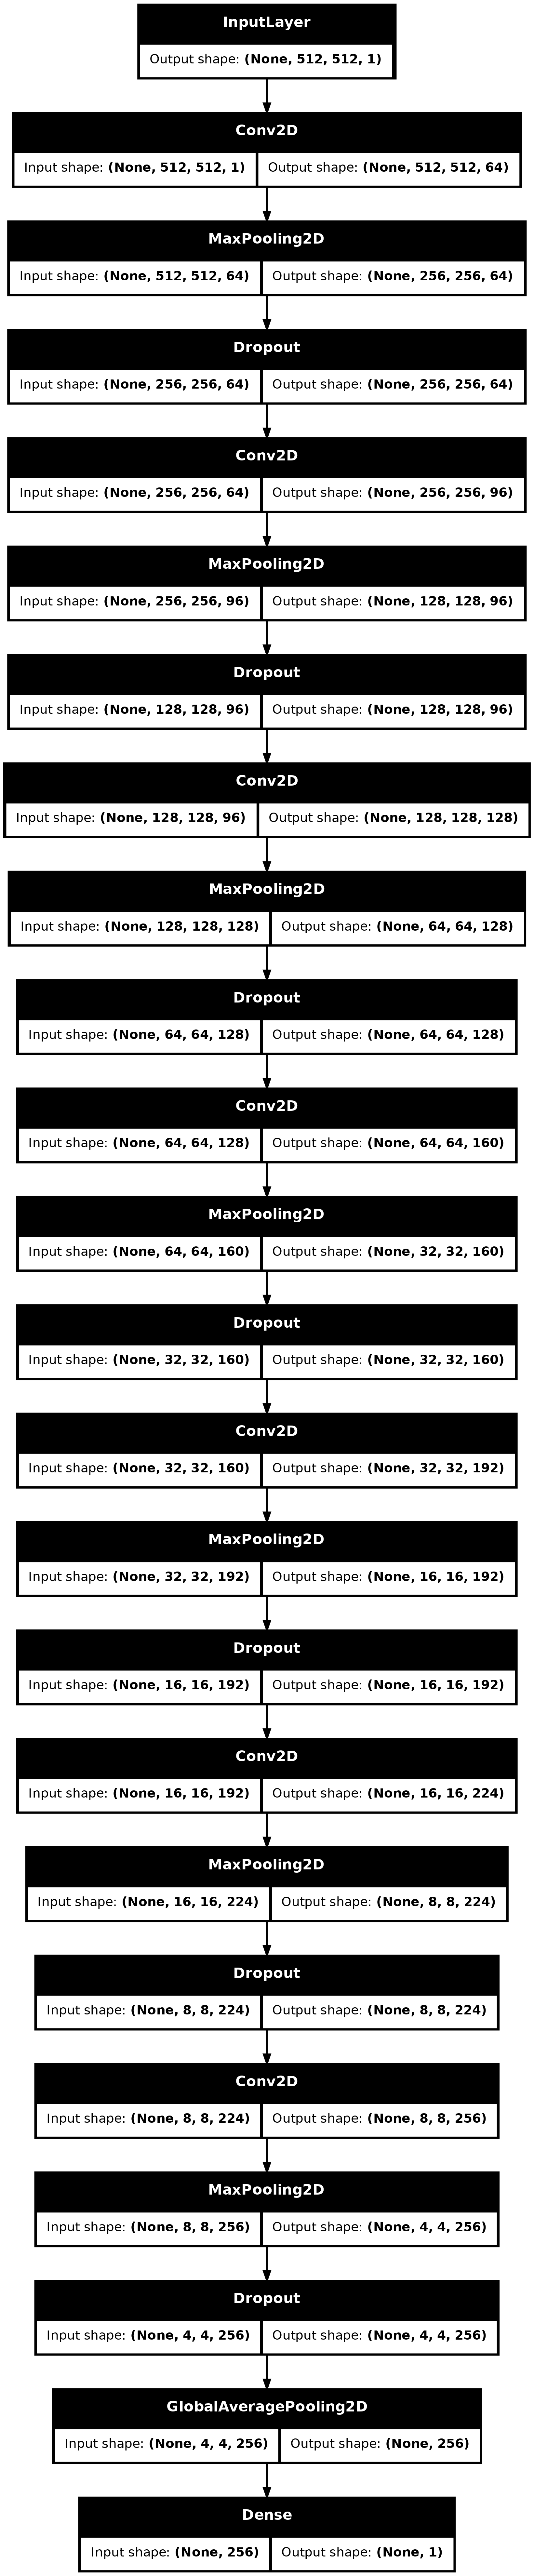

In [16]:
from keras.api.utils import plot_model

# See graphical representation of the model
plot_model(model, show_shapes=True)

In [17]:
# Set up exponential learning rate decay
def lr_decay(epoch):
    """
    Create a learning rate reduction scheduler
    
    Arguments:
        epoch (int): The index of the current epoch        
        
    Returns:
        lr (float): Learning rate as of epoch
    """
    
    initial_lr = 0.001    
    lr = initial_lr * np.exp(-0.1 * epoch)
    return lr

In [18]:
# Import classes for metric saving, model saving, and LR reduction
from keras.src.callbacks import CSVLogger, ModelCheckpoint, LearningRateScheduler

lr_scheduler = LearningRateScheduler(lr_decay, 1)
csv_logger = CSVLogger(filename='Tuberculosis.csv')
model_checkpoint = ModelCheckpoint(filepath='Tuberculosis_{epoch:04d}.keras')

In [19]:
# Calculate the number of steps for training and validation
train_steps = train_gen.samples // BATCH_SIZE
val_steps = val_gen.samples // BATCH_SIZE

In [20]:

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  1


In [21]:
model.load_weights('Tuberculosis_0009.keras')

/home/prazzity/anaconda3/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 33 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [26]:
history = model.fit(feed_data(train_data),                    
                    epochs=33,
                    steps_per_epoch=train_steps,                    
                    validation_data=(feed_data(val_data)),
                    validation_steps=val_steps,                    
                    shuffle=False,
                    callbacks=[lr_scheduler, csv_logger, model_checkpoint])


Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/33


2024-06-09 19:50:45.006375: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout_1/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2024-06-09 19:50:45.585161: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907
2024-06-09 19:50:45.793060: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-06-09 19:50:46.590144: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-06-09 19:50:47.804652: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f78d8844570 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-06-09 19:50:47.804684: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 

166/166 [==============================] - 77s 409ms/step - loss: 0.6449 - accuracy: 0.7060 - val_loss: 0.1708 - val_accuracy: 0.9629 - lr: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.0009048374180359595.
Epoch 2/33


2024-06-09 19:52:02.710378: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 6.23GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-06-09 19:52:02.861034: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 6.23GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


166/166 [==============================] - 43s 235ms/step - loss: 0.1959 - accuracy: 0.9331 - val_loss: 0.0855 - val_accuracy: 0.9829 - lr: 9.0484e-04

Epoch 3: LearningRateScheduler setting learning rate to 0.0008187307530779819.
Epoch 3/33
166/166 [==============================] - 38s 232ms/step - loss: 0.1743 - accuracy: 0.9463 - val_loss: 0.0995 - val_accuracy: 0.9800 - lr: 8.1873e-04

Epoch 4: LearningRateScheduler setting learning rate to 0.0007408182206817179.
Epoch 4/33
166/166 [==============================] - 37s 225ms/step - loss: 0.1180 - accuracy: 0.9632 - val_loss: 0.0683 - val_accuracy: 0.9800 - lr: 7.4082e-04

Epoch 5: LearningRateScheduler setting learning rate to 0.0006703200460356394.
Epoch 5/33
166/166 [==============================] - 36s 218ms/step - loss: 0.0967 - accuracy: 0.9680 - val_loss: 0.0343 - val_accuracy: 0.9886 - lr: 6.7032e-04

Epoch 6: LearningRateScheduler setting learning rate to 0.0006065306597126335.
Epoch 6/33
166/166 [=======================

KeyboardInterrupt: 

In [23]:
model.save('model_tuberculosis_09.keras')

In [31]:
import pandas as pd
seven_layer = pd.read_csv("/mnt/e/Polikek/Diplom/Classitfication_disease/Tuberculosis.csv")


In [32]:
def plot_loss(results, title, ylim=None, figsize=(15, 15)):
    """
    Plot the loss metrics from a DataFrame file
    
    Arguments:
        results (pd.DataFrame): DataFrame containing loss metrics
        title (string): Title for the plot
        ylim (float): Limit for the plot's y axis, default=None
        figsize (tuple of ints): Figure size, default=(15, 15)
    """
    
    plt.figure(figsize=figsize)

    for name, result in results:
        val = plt.plot(range(len((result['epoch']))), result['val_loss'],
                       '--', label=name.title()+', Validation', lw=3.0)
        plt.plot(range(len((result['epoch']))), result['loss'], color=val[0].get_color(),
                 label=name.title()+', Training', lw=3.0)

    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.ylim(ylim)
    plt.grid(lw=2, ls='--')

In [33]:
def plot_accuracy(results, title, x_range=20, figsize=(15, 15)):
    """
    Plot the accuracy metrics from a DataFrame file
    
    Arguments:
        results (pd.DataFrame): DataFrame containing accuracy metrics
        title (string): Title for the plot
        ylim (float): Limit for the plot's y axis, default=None
        figsize (tuple of ints): Figure size, default=(15, 15)
    """    
    
    plt.figure(figsize=figsize)

    for name, result in results:
        val = plt.plot(range(len((result['epoch']))), result['val_accuracy'],
                       '--', label=name.title()+', Validation', lw=3.0)
        plt.plot(range(len((result['epoch']))), result['accuracy'], color=val[0].get_color(),
                 label=name.title()+', Training', lw=3.0)

    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(lw=2, ls='--')

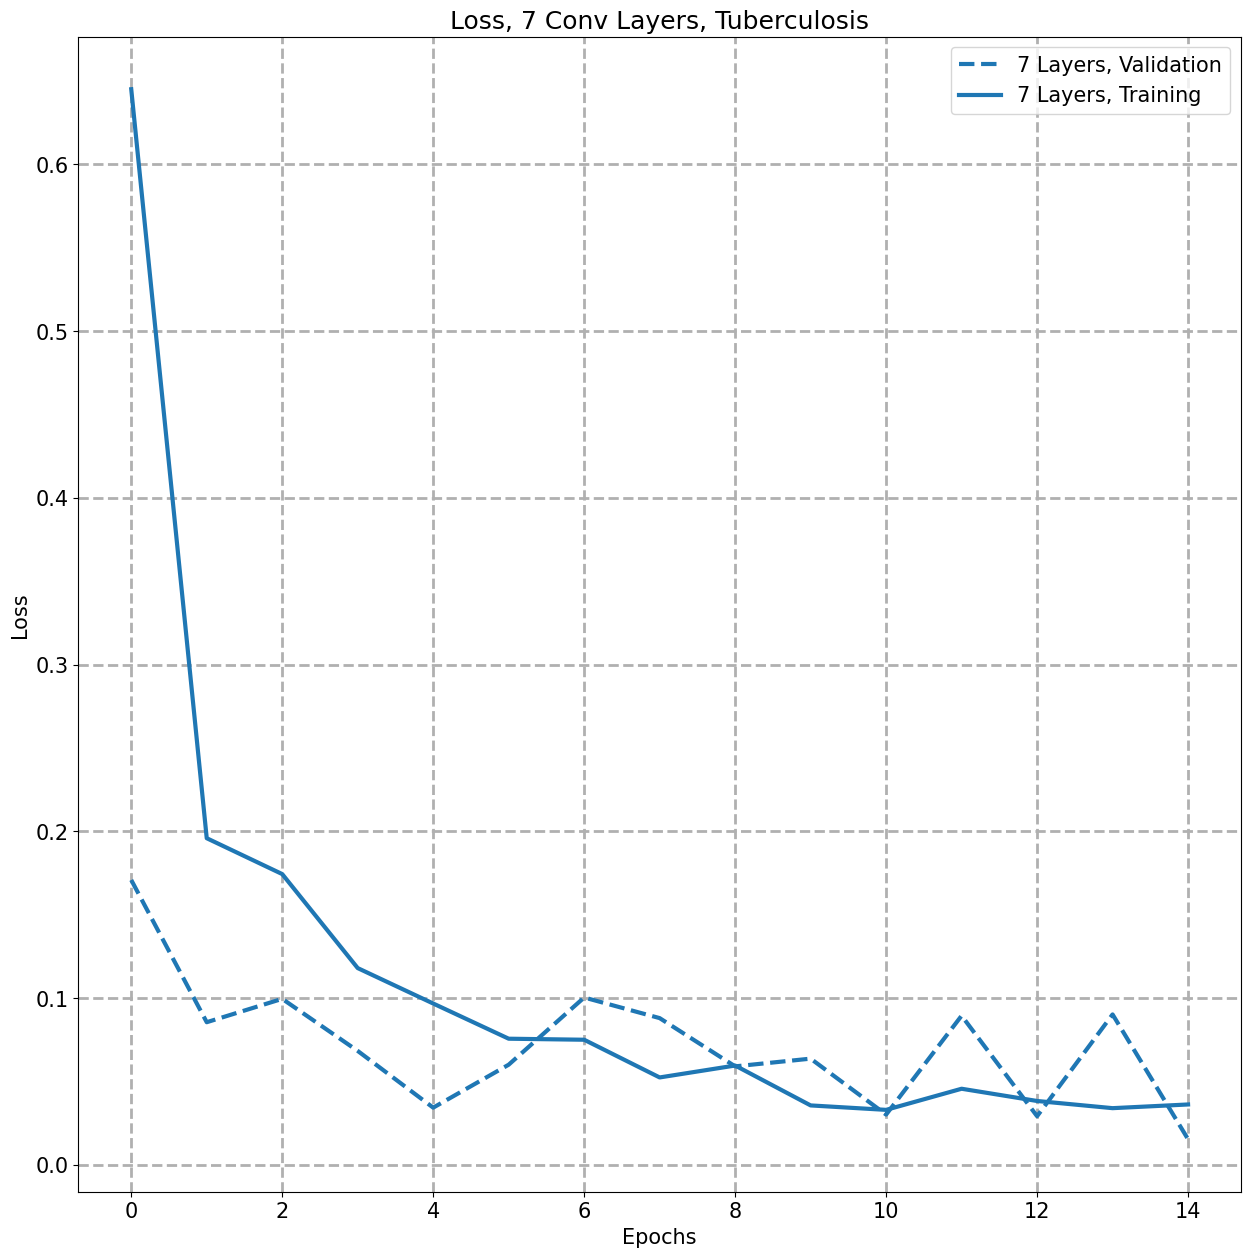

In [36]:
plot_loss([('7 Layers', seven_layer)], 'Loss, 7 Conv Layers, Tuberculosis')

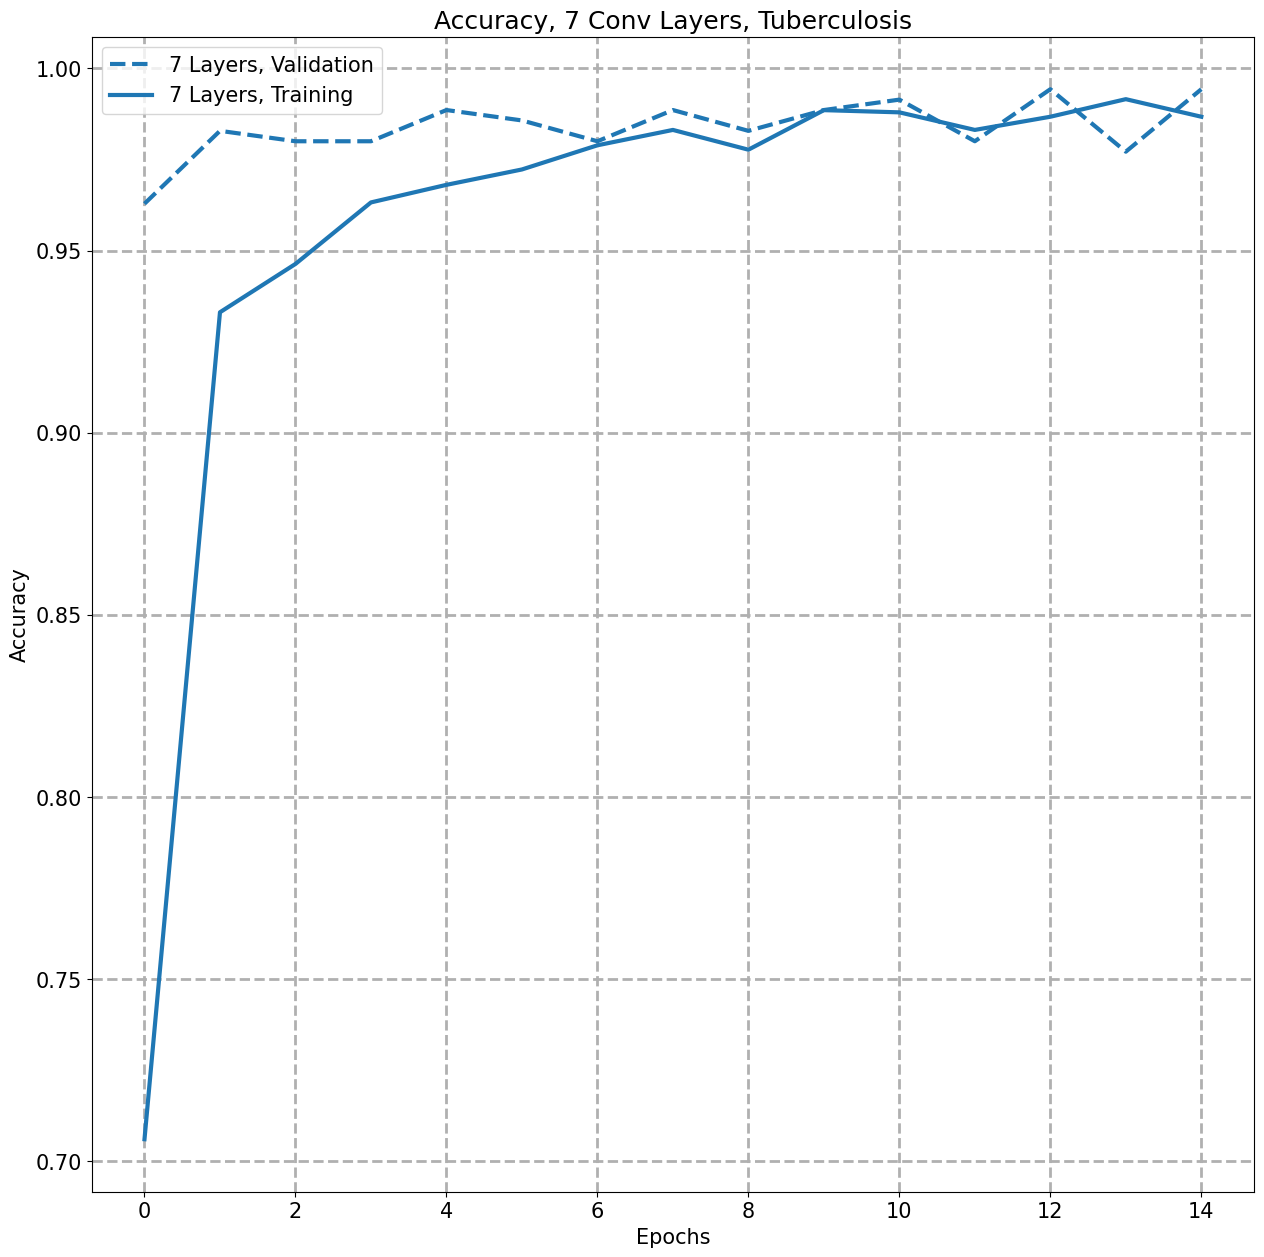

In [37]:
plot_accuracy([('7 Layers', seven_layer)], 'Accuracy, 7 Conv Layers, Tuberculosis')

In [ ]:
# Extract the training and validation loss values from the history object
train_loss = hist.history['loss']
val_loss = hist.history['val_loss']

# Create a list of epoch numbers (1 to number of epochs)
epochs = range(1, len(train_loss) + 1)

# Plot the loss graph
plt.plot(epochs, train_loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [28]:
import keras
# Evaluate the model on the test set
model = keras.models.load_model('Tuberculosis_0009.keras')
test_steps = test_gen.samples // BATCH_SIZE
model.evaluate(test_data, steps=test_steps)

# Declare an image generator on test data for augmented images
test_aug_gen = datagen.flow_from_dataframe(test_df,
                                           target_size=(512, 512),
                                           color_mode='grayscale',
                                           batch_size=BATCH_SIZE,
                                           class_mode='binary',
                                           shuffle=False)

test_aug_data = tf.data.Dataset.from_generator(lambda: test_aug_gen,
                                           output_types=(tf.float32, tf.int32),
                                           output_shapes=([None, 512, 512, 1], [None, ]))

# Evaluate the model on augmented test data
test_aug_steps = test_aug_gen.samples // BATCH_SIZE
model.evaluate(test_aug_data, steps=test_aug_steps)

2024-06-09 20:25:25.060569: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907
2024-06-09 20:25:25.404266: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-06-09 20:25:26.829488: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


35/35 [==============================] - 8s 152ms/step - loss: 0.0302 - accuracy: 0.9914
Found 358 validated image filenames belonging to 2 classes.
35/35 [==============================] - 7s 201ms/step - loss: 0.0422 - accuracy: 0.9914


[0.042151883244514465, 0.991428554058075]

In [29]:
# Calculate precision and recall based on  test data
precision = tf.keras.metrics.Precision()
recall = tf.keras.metrics.Recall()

predictions = model.predict(test_data, steps=test_steps).flatten()
y_true = test_gen.classes[:len(predictions)]

precision.update_state(y_true, predictions)
recall.update_state(y_true, predictions)

35/35 [==============================] - 5s 138ms/step


In [30]:
print('Precision with base test data:', precision.result().numpy())
print('Recall with base test data:', recall.result().numpy())

Precision with base test data: 1.0
Recall with base test data: 0.9756098


In [31]:
# Calculate precision and recall based on augmented test data

precision.reset_state()
recall.reset_state()

predictions_aug = model.predict(test_aug_data, steps=test_steps).flatten()
y_true = test_gen.classes[:len(predictions_aug)]

precision.update_state(y_true, predictions_aug, sample_weight=None)
recall.update_state(y_true, predictions_aug, sample_weight=None)

35/35 [==============================] - 7s 199ms/step


In [32]:
print('Precision with augmented test data:', precision.result().numpy())
print('Recall with augmented test data:', recall.result().numpy())

Precision with augmented test data: 0.9834711
Recall with augmented test data: 0.96747965


In [33]:
from sklearn.metrics import confusion_matrix

confusion_mat = confusion_matrix(y_true, predictions > 0.5)

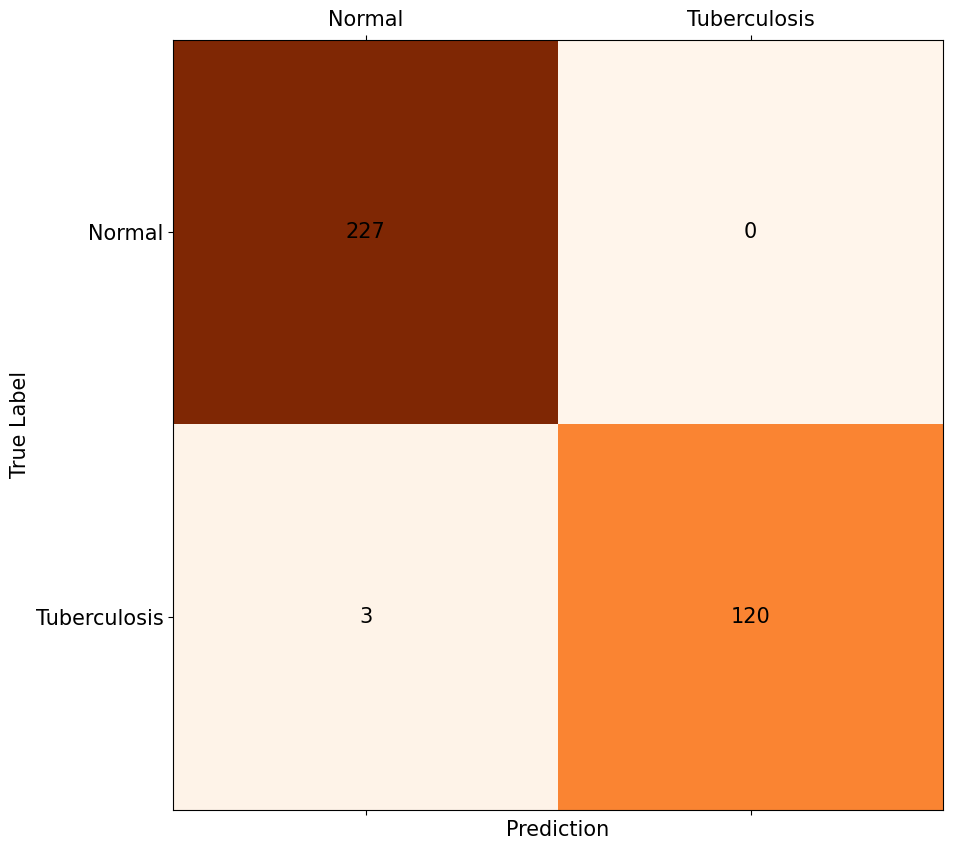

In [39]:
fig, ax = plt.subplots()

ax.matshow(confusion_mat, cmap=plt.cm.Oranges)

ax.set_xlabel('Prediction')
ax.set_ylabel('True Label')

tick_labels = ['Normal', 'Tuberculosis']

ax.set_xticks(range(len(tick_labels)))
ax.set_yticks(range(len(tick_labels)))
ax.set_xticklabels(tick_labels)
ax.set_yticklabels(tick_labels)

for i in range(len(tick_labels)):
    for j in range(len(tick_labels)):
        ax.text(j, i, confusion_mat[i, j],
               ha='center', va='center')
        
plt.show()

In [40]:
#from keras.api.preprocessing.image import array_to_img
from keras.preprocessing.image import array_to_img

def plot_image(image, prediction, label):
    """
    Plot images along with predictions and true labels
    
    Arguments:
        image (4-D array): The image to visualize
        prediction (2-D array): Model's prediction on the image
        label (1-D array): True label of the image
    """
    
    label_names = ['Normal', 'Tuberculosis']    
        
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    plt.imshow(array_to_img(image * 255), interpolation='nearest', cmap='gray')
    
    if prediction <= 0.6:
        predicted_label = 0
    else:
        predicted_label = 1

    if predicted_label == label:
        color = 'blue'
    else:
        color = 'red' 
    
    plt.xlabel("{} {:2.0f}% \n ({})".format(label_names[predicted_label], 100 * prediction[0], label_names[label]), color=color)

1/1 [==============================] - 0s 23ms/step


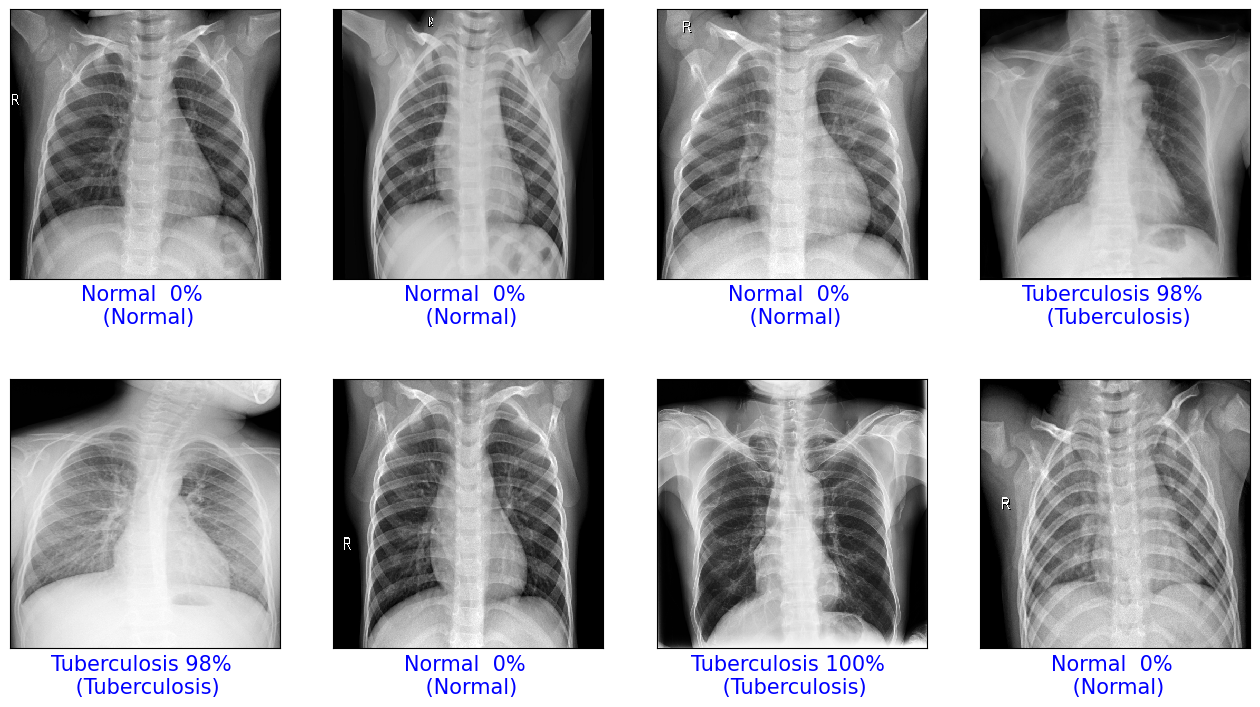

In [42]:
images, labels = next(iter(test_data))
y_pred = model.predict(images)
num_rows = 2
num_cols = 4
num_images = num_rows * num_cols
plt.figure(figsize=(2*2*num_cols, 2.2*2*num_rows))

for i in range(num_images):
    plt.subplot(num_rows, num_cols, i+1)
    plot_image(images[i], y_pred[i], labels[i])
plt.show()